# G@C Recycling Volume vs Operating Cost

Model Summary:
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -558.2707    918.663     -0.608      0.563   -2730.565    1614.023
cost_HKD    8.441e-05   4.11e-06     20.534      0.000    7.47e-05    9.41e-05

R-squared: 0.9837


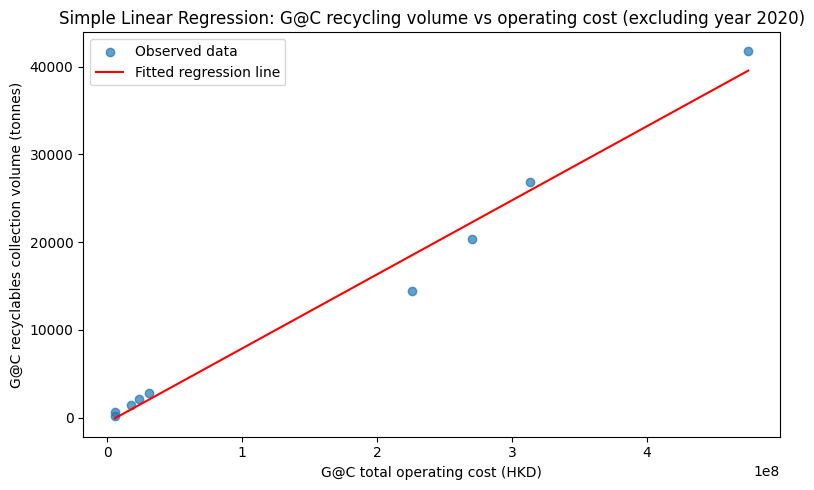

In [3]:
# !pip install pandas numpy matplotlib scikit-learn statsmodels openpyxl
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Load the dataset (HK MSW Volume and Recycling Rat sheet is the default first sheet)
df = pd.read_excel("../General Stats_G@C_clean.xlsx")

# ---------- Simple Linear Regression: G@C recycling volume vs operating cost ----------

# We already loaded:
# df = pd.read_excel("../General Stats_G@C_clean.xlsx")

from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import matplotlib.pyplot as plt

data_path = "../General Stats_G@C_clean.xlsx"

# ----- 1. Get G@C recycling volume (tonnes) from the main HK MSW sheet -----
sheet_msw = "HK MSW Volume and Recycling Rat"
df_msw = pd.read_excel(data_path, sheet_name=sheet_msw)

col_year   = "Year"
col_volume = "G@C recyclables collection volume (tonnes)"

# Clean volume numbers like "26,900.0" → 26900.0
vol_series = pd.to_numeric(
    df_msw[col_volume].astype(str).str.replace(",", ""),
    errors="coerce"
)
year_series = df_msw[col_year]

mask_vol = vol_series.notna()
vol_df = pd.DataFrame({
    "Year": year_series[mask_vol].astype(int),
    "volume_tonnes": vol_series[mask_vol]
})

# ----- 2. Get G@C total operating cost from the cost sheet -----
sheet_cost = "G@C Recyclables Collection Volu"
df_cost = pd.read_excel(data_path, sheet_name=sheet_cost)

col_cost = "G@C total operating cost"

# Financial-year labels like "2015-16" → base year 2015
cost_years = df_cost["Year"].astype(str).str.slice(0, 4).astype(int)

cost_series = pd.to_numeric(
    df_cost[col_cost].astype(str).str.replace(",", ""),
    errors="coerce"
)

cost_df = pd.DataFrame({
    "Year": cost_years,
    "cost_HKD": cost_series
})

# ----- 3. Merge by calendar year and EXCLUDE 2020 -----
merged = vol_df.merge(cost_df, on="Year", how="inner")

# Drop year 2020 as required
merged = merged[merged["Year"] != 2020]

# Prepare data for regression
X2 = merged[["cost_HKD"]]              # predictor: total operating cost (HKD)
y  = merged["volume_tonnes"]           # response: G@C recycling volume (tonnes)

# ----- 4. Fit model using sklearn for predictions -----
lin_reg2 = LinearRegression()
lin_reg2.fit(X2, y)

# ----- 5. Fit model using statsmodels for statistical tests -----
X2_sm = sm.add_constant(X2)  # Add constant term for intercept
model = sm.OLS(y, X2_sm)
results = model.fit()

# Predictions for plotting
y_pred2 = lin_reg2.predict(X2)

print("Model Summary:")
print(results.summary().tables[1])  # coefficient table
print(f"\nR-squared: {results.rsquared:.4f}")

# ----- 6. Plot scatter + regression line -----
plt.figure(figsize=(8, 5))
plt.scatter(X2, y, alpha=0.7, label="Observed data")
plt.plot(X2, y_pred2, color="red", label="Fitted regression line")
plt.xlabel("G@C total operating cost (HKD)")
plt.ylabel("G@C recyclables collection volume (tonnes)")
plt.title("Simple Linear Regression: G@C recycling volume vs operating cost (excluding year 2020)")
plt.legend()
plt.tight_layout()
plt.show()


**Operating-cost coefficient ($\hat \beta_1$) ≈ 0.000084 (p ≈ 0.0000 < 0.05)**  

- There is a **strong, statistically significant positive association** between G@C total operating cost and the recyclables collection volume: higher spending on G@C is associated with substantially higher collected tonnage.  

- The model explains **about 98% of the variance** in G@C recycling volume R-squared approx 0.98, meaning that changes in operating cost account for most of the year-to-year variation in collected volume (though results are based on a small number of years and should be interpreted with caution for prediction outside this range).
